# test_kse.ipynb

### Install

In [ ]:
pip install git+https://github.com/grmacchio/dynml.git

### Imports, Random Seeds, and Data Type Settings

In [2]:
from random import seed
from math import floor

from matplotlib.pyplot import subplots, show
from torch import arange, float64, linspace, set_default_dtype
from torch.fft import irfft
from torch.linalg import norm
from torch.random import manual_seed as torch_manual_seed
from torch.cuda.random import manual_seed as cuda_manual_seed
from numpy import round

from dynml.dyn.cont.ode.firstorder.discretize import gen_approx_discrete_sys
from dynml.examples.kse import KSE
from dynml.dyn.discrete.numsolve import gen_num_trajs

In [3]:
seed(0)                                                                         # set the random seed
torch_manual_seed(0)                                                            # set the torch random seed
cuda_manual_seed(0)                                                             # set the cuda random seed

In [4]:
set_default_dtype(float64)                                                      # set the default data type

### Generate State Space Trajectories

In [5]:
K = 32                                                                          # set number of fourier modes
L = 11.0                                                                        # set the domain length
first_order_sys = KSE(K, L)                                                     # semi-linear first order system

dt = 0.01                                                                       # set the time step
discretization_method = 'rk3cn'                                                 # set the discretization method
implicit_solver = 'diag'                                                        # set the implicit solver
discrete_sys = gen_approx_discrete_sys(first_order_sys, dt,                     # generate the discrete system
                                       discretization_method, implicit_solver)

num_traj_sqrt = 2                                                               # set the square root of the number of trajectories for plotting
num_traj = num_traj_sqrt**2                                                     # set the number of trajectories
t_final = 100.0                                                                 # set the final time
num_samples = floor(t_final/dt) + 1                                             # set the number of samples
trajs = gen_num_trajs(discrete_sys, first_order_sys.gen_ic, num_traj,           # generate the trajectories
                      num_samples, compute='cpu', output='cpu', pbar=True)

100%|██████████| 10000/10000 [00:02<00:00, 4653.49it/s]


### Plot the Norm of State Space Trajectories

In [6]:
norms = norm(trajs, dim=-1)                                                     # compute the norms of the trajectories

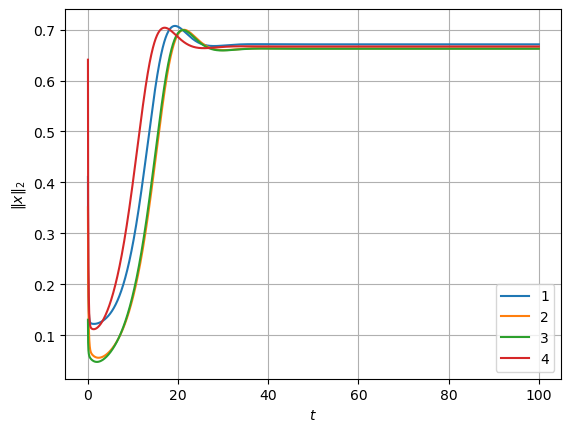

In [7]:
num_traj_plot = num_traj                                                        # set the number of trajectories to plot
t = linspace(0, t_final, num_samples)                                           # generate the time vector
fig, ax = subplots()                                                            # generate the figure and axis
for i in range(num_traj):                                                       # loop over the trajectories
    ax.plot(t, norms[i], label=f'{i + 1}')                                      # plot the norms
ax.set_xlabel('$t$')                                                            # set the x-axis label
ax.set_ylabel('$\\|x\\|_2$')                                                    # set the y-axis label
ax.legend()                                                                     # add the legend
ax.grid()                                                                       # add the grid
show()                                                                          # show the plot

### Plot Heat Maps of Collocation Space Trajectories

In [9]:
u = first_order_sys.state_to_phys(trajs)                                        # convert the trajectories to physical space

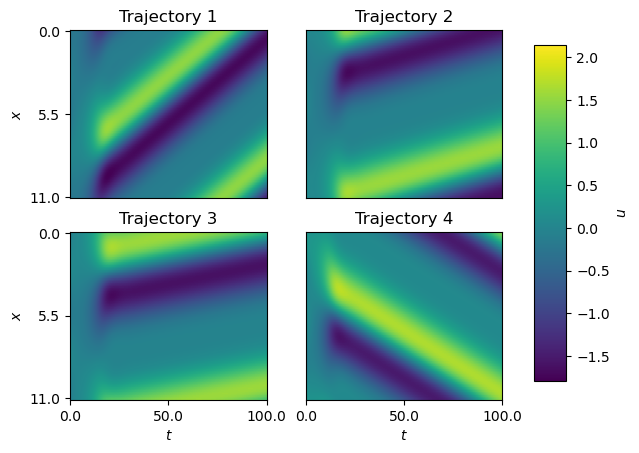

In [10]:
dt_plot = 50.0                                                                  # set the time step for the x-axis ticks
dx = L / (2 * K)                                                                # set the space step
dx_plot = K * dx                                                                # set the space step for the y-axis ticks
x = linspace(0, L, 2 * K + 1)                                                   # generate the space vector
fig, axs = subplots(num_traj_sqrt, num_traj_sqrt)                               # generate the figure and subplots
u_max = u.max()                                                                 # compute the maximum value of the trajectories
u_min = u.min()                                                                 # compute the minimum value of the trajectories
for i in range(num_traj_sqrt):                                                  # loop over the rows                  
    for j in range(num_traj_sqrt):                                              # loop over the columns
        ax = axs[i, j]                                                          # select the subplot
        im = ax.imshow(u[i * num_traj_sqrt + j].T, aspect='auto',               # plot the collocation form of the trajectory
                       vmin=u_min, vmax=u_max)                                  # set the color limits
        ax.set_title(f'Trajectory {i * num_traj_sqrt + j + 1}')                 # set the title
        if j == 0:                                                              # if the column index is zero
            ax.set_ylabel('$x$')                                                # set the y-axis label
            ax.set_yticks(arange(0, 2 * K + 1, int(dx_plot/dx)).numpy())        # set the y-axis tick positions
            ax.set_yticklabels(round(x[::int(dx_plot/dx)].numpy(), 2))          # set the y-axis tick labels
        else:                                                                   # if the column index is not zero
            ax.set_yticks([])                                                   # remove the y-axis
        if i == num_traj_sqrt - 1:                                              # if the row index is the last
            ax.set_xlabel('$t$')                                                # set the x-axis label
            ax.set_xticks(arange(0, num_samples, int(dt_plot/dt)).numpy())      # set the x-axis tick positions
            ax.set_xticklabels(t[::int(dt_plot/dt)].numpy())                    # set the x-axis tick labels
        else:                                                                   # if the row index is not the last
            ax.set_xticks([])                                                   # remove the x-axis
fig.subplots_adjust(right=0.8)                                                  # adjust the figure
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])                                     # add the colorbar axis
cbar = fig.colorbar(im, cax=cax)                                                # add the colorbar
cbar.set_label('$u$')                                                           # set the colorbar label
show()                                                                          # show the plot